In [34]:
import wandb
import torch
import os
import matplotlib.pyplot as plt
from datagenfordiff.datasetdif import SynthSignalsDataset
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
# from diff_ts_class import EpsilonThetaClass
# from diff_ts_class import GaussianDiffusionClass

In [62]:

import math

import torch
from torch import nn
import torch.nn.functional as F

class DiffusionEmbedding(nn.Module):
    def __init__(self, dim, proj_dim, max_steps=256):
        super().__init__()
        self.register_buffer(
            "embedding", self._build_embedding(dim, max_steps), persistent=False
        )
        self.projection1 = nn.Linear(2*dim , proj_dim)
        self.projection2 = nn.Linear(proj_dim, proj_dim)

    def forward(self, diffusion_step):
        x = self.embedding[diffusion_step]
        x = self.projection1(x)
        x = F.silu(x)
        x = self.projection2(x)
        x = F.silu(x)
        return x

    def _build_embedding(self, dim, max_steps):
        steps = torch.arange(max_steps).unsqueeze(1)  # [T,1]
        dims = torch.arange(dim).unsqueeze(0)  # [1,dim]
        table = steps * 10.0 ** (dims * 4.0 / dim)  # [T,dim]
        table = torch.cat([torch.sin(table), torch.cos(table)], dim=1)
        return table
class ResidualBlock(nn.Module):
    def __init__(self, hidden_size, residual_channels, dilation, dropout_rate=0.1):
        super().__init__()
        self.dilated_conv = nn.Conv1d(
            residual_channels,
            2 * residual_channels,
            3,
            padding=(dilation * (3 - 1)) // 2,
            dilation=dilation,
            padding_mode='reflect',  # Adjust padding mode if necessary
        )
        self.diffusion_projection = nn.Linear(hidden_size, residual_channels)
        self.output_projection = nn.Conv1d(residual_channels, 2 * residual_channels, 1)
        self.dropout = nn.Dropout(dropout_rate)

        nn.init.kaiming_normal_(self.output_projection.weight)

    def forward(self, x, diffusion_step):
        diffusion_step = self.diffusion_projection(diffusion_step).unsqueeze(-1)

        y = x + diffusion_step
        y = self.dilated_conv(y)

        gate, filter = torch.chunk(y, 2, dim=1)
        y = torch.sigmoid(gate) * torch.tanh(filter)

        y = self.output_projection(y)
        y = F.leaky_relu(y, 0.4)
        y = self.dropout(y)

        residual, skip = torch.chunk(y, 2, dim=1)
        return (x + residual) / math.sqrt(2.0), skip

class EpsilonThetaClass(nn.Module):
    def __init__(
        self,
        num_classes = 5,
        dropout_rate=0.1,
        #cond_length,
        time_emb_dim=8,
        residual_layers=8,
        residual_channels=16,
        dilation_cycle_length=2,
        residual_hidden=16,
        class_emb_dim=5,
        target_dim=1,
        
    ):
        super().__init__()
        self.class_embedding = nn.Embedding(num_classes, class_emb_dim)
        
        self.input_projection = nn.Conv1d(
            1+class_emb_dim, residual_channels, 1, padding=2, padding_mode="zeros"
        )
        self.diffusion_embedding = DiffusionEmbedding(
            time_emb_dim, proj_dim=residual_hidden
        )
        self.residual_layers = nn.ModuleList()
        for i in range(residual_layers):
            # Cycle through a range of dilation rates
            dilation = 2 ** (i % dilation_cycle_length)
            self.residual_layers.append(ResidualBlock(
                hidden_size=residual_hidden,
                residual_channels=residual_channels,
                dilation=dilation,
                dropout_rate=dropout_rate,  # Pass the dropout rate to each block
            ))
        self.skip_projection = nn.Conv1d(residual_channels, residual_channels, 3)
        self.output_projection = nn.Conv1d(residual_channels, target_dim, 3)

        nn.init.kaiming_normal_(self.input_projection.weight)
        nn.init.kaiming_normal_(self.skip_projection.weight)
        nn.init.kaiming_normal_(self.output_projection.weight)

    def forward(self, inputs, time, class_labels):
        class_embeddings = self.class_embedding(class_labels)  # [batch_size, class_emb_dim]
        class_embeddings = class_embeddings.unsqueeze(2).expand(-1, -1, inputs.size(2))

        # Concatenate class embeddings with inputs
        inputs = torch.cat([inputs, class_embeddings], dim=1)

        x = self.input_projection(inputs)
        x = F.leaky_relu(x, 0.4)

        diffusion_step = self.diffusion_embedding(time)
        skip = []
        for layer in self.residual_layers:
            x, skip_connection = layer(x, diffusion_step)
            skip.append(skip_connection)

        x = torch.sum(torch.stack(skip), dim=0) / math.sqrt(len(self.residual_layers))
        x = self.skip_projection(x)
        x = F.leaky_relu(x, 0.4)
        x = self.output_projection(x)
        return x

from functools import partial
from inspect import isfunction

import numpy as np

import torch
from torch import nn, einsum
import torch.nn.functional as F


#  COND HAS BEEN TAKEN OUT FROM FUNCTIONS


def default(val, d):
    if val is not None:
        return val
    return d() if isfunction(d) else d


def extract(a, t, x_shape):
    b, *_ = t.shape
    out = a.gather(-1, t)
    return out.reshape(b, *((1,) * (len(x_shape) - 1)))


def noise_like(shape, device, repeat=False):
    repeat_noise = lambda: torch.randn((1, *shape[1:]), device=device).repeat(
        shape[0], *((1,) * (len(shape) - 1))
    )
    noise = lambda: torch.randn(shape, device=device)
    return repeat_noise() if repeat else noise()


def cosine_beta_schedule(timesteps, s=0.008):
    """
    cosine schedule
    as proposed in https://openreview.model/forum?id=-NEXDKk8gZ
    """
    steps = timesteps + 1
    x = np.linspace(0, timesteps, steps)
    alphas_cumprod = np.cos(((x / timesteps) + s) / (1 + s) * np.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return np.clip(betas, 0, 0.999)


class GaussianDiffusionClass(nn.Module):
    def __init__(
        self,
        denoise_fn,#pass epsilon theta
        input_size,
        beta_end=0.1,
        diff_steps=100,
        loss_type="l2",
        betas=None,
        beta_schedule="linear",
    ):
        super().__init__()
        self.denoise_fn = denoise_fn
        self.input_size = input_size
        self.__scale = None

        if betas is not None:
            betas = (
                betas.detach().cpu().numpy()
                if isinstance(betas, torch.Tensor)
                else betas
            )
        else:
            if beta_schedule == "linear":
                betas = np.linspace(1e-4, beta_end, diff_steps)
            elif beta_schedule == "quad":
                betas = np.linspace(1e-4 ** 0.5, beta_end ** 0.5, diff_steps) ** 2
            elif beta_schedule == "const":
                betas = beta_end * np.ones(diff_steps)
            elif beta_schedule == "jsd":  # 1/T, 1/(T-1), 1/(T-2), ..., 1
                betas = 1.0 / np.linspace(diff_steps, 1, diff_steps)
            elif beta_schedule == "sigmoid":
                betas = np.linspace(-6, 6, diff_steps)
                betas = (beta_end - 1e-4) / (np.exp(-betas) + 1) + 1e-4
            elif beta_schedule == "cosine":
                betas = cosine_beta_schedule(diff_steps)
            else:
                raise NotImplementedError(beta_schedule)

        alphas = 1.0 - betas
        alphas_cumprod = np.cumprod(alphas, axis=0)
        alphas_cumprod_prev = np.append(1.0, alphas_cumprod[:-1])

        (timesteps,) = betas.shape
        self.num_timesteps = int(timesteps)
        self.loss_type = loss_type

        to_torch = partial(torch.tensor, dtype=torch.float32)

        self.register_buffer("betas", to_torch(betas))
        self.register_buffer("alphas_cumprod", to_torch(alphas_cumprod))
        self.register_buffer("alphas_cumprod_prev", to_torch(alphas_cumprod_prev))

        # calculations for diffusion q(x_t | x_{t-1}) and others
        self.register_buffer("sqrt_alphas_cumprod", to_torch(np.sqrt(alphas_cumprod)))
        self.register_buffer(
            "sqrt_one_minus_alphas_cumprod", to_torch(np.sqrt(1.0 - alphas_cumprod))
        )
        self.register_buffer(
            "log_one_minus_alphas_cumprod", to_torch(np.log(1.0 - alphas_cumprod))
        )
        self.register_buffer(
            "sqrt_recip_alphas_cumprod", to_torch(np.sqrt(1.0 / alphas_cumprod))
        )
        self.register_buffer(
            "sqrt_recipm1_alphas_cumprod", to_torch(np.sqrt(1.0 / alphas_cumprod - 1))
        )

        # calculations for posterior q(x_{t-1} | x_t, x_0)
        posterior_variance = (
            betas * (1.0 - alphas_cumprod_prev) / (1.0 - alphas_cumprod)
        )
        # above: equal to 1. / (1. / (1. - alpha_cumprod_tm1) + alpha_t / beta_t)
        self.register_buffer("posterior_variance", to_torch(posterior_variance))
        # below: log calculation clipped because the posterior variance is 0 at the beginning of the diffusion chain
        self.register_buffer(
            "posterior_log_variance_clipped",
            to_torch(np.log(np.maximum(posterior_variance, 1e-20))),
        )
        self.register_buffer(
            "posterior_mean_coef1",
            to_torch(betas * np.sqrt(alphas_cumprod_prev) / (1.0 - alphas_cumprod)),
        )
        self.register_buffer(
            "posterior_mean_coef2",
            to_torch(
                (1.0 - alphas_cumprod_prev) * np.sqrt(alphas) / (1.0 - alphas_cumprod)
            ),
        )

    @property
    def scale(self):
        return self.__scale

    @scale.setter
    def scale(self, scale):
        self.__scale = scale

    def q_mean_variance(self, x_start, t):
        mean = extract(self.sqrt_alphas_cumprod, t, x_start.shape) * x_start
        variance = extract(1.0 - self.alphas_cumprod, t, x_start.shape)
        log_variance = extract(self.log_one_minus_alphas_cumprod, t, x_start.shape)
        return mean, variance, log_variance

    def predict_start_from_noise(self, x_t, t, noise):
        return (
            extract(self.sqrt_recip_alphas_cumprod, t, x_t.shape) * x_t
            - extract(self.sqrt_recipm1_alphas_cumprod, t, x_t.shape) * noise
        )

    def q_posterior(self, x_start, x_t, t):
        posterior_mean = (
            extract(self.posterior_mean_coef1, t, x_t.shape) * x_start
            + extract(self.posterior_mean_coef2, t, x_t.shape) * x_t
        )
        posterior_variance = extract(self.posterior_variance, t, x_t.shape)
        posterior_log_variance_clipped = extract(
            self.posterior_log_variance_clipped, t, x_t.shape
        )
        return posterior_mean, posterior_variance, posterior_log_variance_clipped

    def p_mean_variance(self, x, t, class_labels, clip_denoised: bool):
        x_recon = self.predict_start_from_noise(
            x, t=t, noise=self.denoise_fn(x, t, class_labels)
        )

        if clip_denoised:
            x_recon.clamp_(-1.0, 1.0)

        model_mean, posterior_variance, posterior_log_variance = self.q_posterior(
            x_start=x_recon, x_t=x, t=t
        )
        return model_mean, posterior_variance, posterior_log_variance
    
    @torch.no_grad()
    def q_sample_loop(self,x_0, shape):
        device = self.betas.device

        b=shape[0]
        img=torch.empty(self.num_timesteps, *shape)
        for i in range(0, self.num_timesteps) :
            img[i]=self.q_sample(x_0, torch.full((b,), i, device=device, dtype=torch.long))
        return img

    @torch.no_grad()
    def p_sample(self, x, t, class_labels, clip_denoised=False, repeat_noise=False):
        b, *_, device = *x.shape, x.device
        model_mean, _, model_log_variance = self.p_mean_variance(
            x=x, t=t, class_labels = class_labels, clip_denoised=clip_denoised
        )
        noise = noise_like(x.shape, device, repeat_noise)
        # no noise when t == 0
        nonzero_mask = (1 - (t == 0).float()).reshape(b, *((1,) * (len(x.shape) - 1)))
        return model_mean + nonzero_mask * (0.5 * model_log_variance).exp() * noise

    @torch.no_grad()
    def p_sample_loop(self, x, class_labels):
        device = self.betas.device

        b = x.shape[0]
        img = torch.randn(x.shape, device=device)

        for i in reversed(range(0, self.num_timesteps)):
            img = self.p_sample(
                img, torch.full((b,), i, device=device, dtype=torch.long), class_labels
            )
        return img
    

    @torch.no_grad()
    def sample(self, class_labels, sample_shape=torch.Size(), cond=None):
        if cond is not None:
            shape = cond.shape[:-1] + (self.input_size,)
            # TODO reshape cond to (B*T, 1, -1)
        else:
            shape = sample_shape
        x_hat = self.p_sample_loop(shape, class_labels, cond)  # TODO reshape x_hat to (B,T,-1)

        if self.scale is not None:
            x_hat *= self.scale
        return x_hat

    @torch.no_grad()
    def interpolate(self, x1, x2,class_labels, t=None, lam=0.5):
        b, *_, device = *x1.shape, x1.device
        t = default(t, self.num_timesteps - 1)

        assert x1.shape == x2.shape

        t_batched = torch.stack([torch.tensor(t, device=device)] * b)
        xt1, xt2 = map(lambda x: self.q_sample(x, t=t_batched), (x1, x2))

        img = (1 - lam) * xt1 + lam * xt2
        for i in reversed(range(0, t)):
            img = self.p_sample(
                img, torch.full((b,), i, device=device, dtype=torch.long), class_labels
            )

        return img

    def q_sample(self, x_start, t, noise=None):
        noise = default(noise, lambda: torch.randn_like(x_start))

        return (
            extract(self.sqrt_alphas_cumprod, t, x_start.shape) * x_start
            + extract(self.sqrt_one_minus_alphas_cumprod, t, x_start.shape) * noise
        )

    def p_losses(self, x_start, t, class_labels, noise=None):
        noise = default(noise, lambda: torch.randn_like(x_start))

        x_noisy = self.q_sample(x_start=x_start, t=t, noise=noise)
        x_recon = self.denoise_fn(x_noisy, t, class_labels)

        if self.loss_type == "l1":
            loss = F.l1_loss(x_recon, noise)
        elif self.loss_type == "l2":
            loss = F.mse_loss(x_recon, noise)
        elif self.loss_type == "huber":
            loss = F.smooth_l1_loss(x_recon, noise)
        else:
            raise NotImplementedError()

        return loss

    def log_prob(self, x, class_labels,*args, **kwargs):
        if self.scale is not None:
            x /= self.scale

        B, T, _ = x.shape

        time = torch.randint(0, self.num_timesteps, (B * T,), device=x.device).long()
        loss = self.p_losses(
            x.reshape(B * T, 1, -1),  time, class_labels,*args, **kwargs
        )

        return loss
    
    
        


In [110]:
run = wandb.init(project="test_train_class")
artifact = run.use_artifact('fyp_a/test_train_class/resch16_reshid16_classemb5:v1')
artifact_dir = artifact.download()
model=GaussianDiffusionClass(EpsilonThetaClass(), input_size = 256)
model.load_state_dict(torch.load(f"{artifact_dir}/resch16_reshid16_classemb5.pth"))


wandb:   1 of 1 files downloaded.  


<All keys matched successfully>

In [111]:
model.eval()

GaussianDiffusionClass(
  (denoise_fn): EpsilonThetaClass(
    (class_embedding): Embedding(5, 5)
    (input_projection): Conv1d(6, 16, kernel_size=(1,), stride=(1,), padding=(2,))
    (diffusion_embedding): DiffusionEmbedding(
      (projection1): Linear(in_features=16, out_features=16, bias=True)
      (projection2): Linear(in_features=16, out_features=16, bias=True)
    )
    (residual_layers): ModuleList(
      (0): ResidualBlock(
        (dilated_conv): Conv1d(16, 32, kernel_size=(3,), stride=(1,), padding=(1,), padding_mode=reflect)
        (diffusion_projection): Linear(in_features=16, out_features=16, bias=True)
        (output_projection): Conv1d(16, 32, kernel_size=(1,), stride=(1,))
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (1): ResidualBlock(
        (dilated_conv): Conv1d(16, 32, kernel_size=(3,), stride=(1,), padding=(2,), dilation=(2,), padding_mode=reflect)
        (diffusion_projection): Linear(in_features=16, out_features=16, bias=True)
        (o

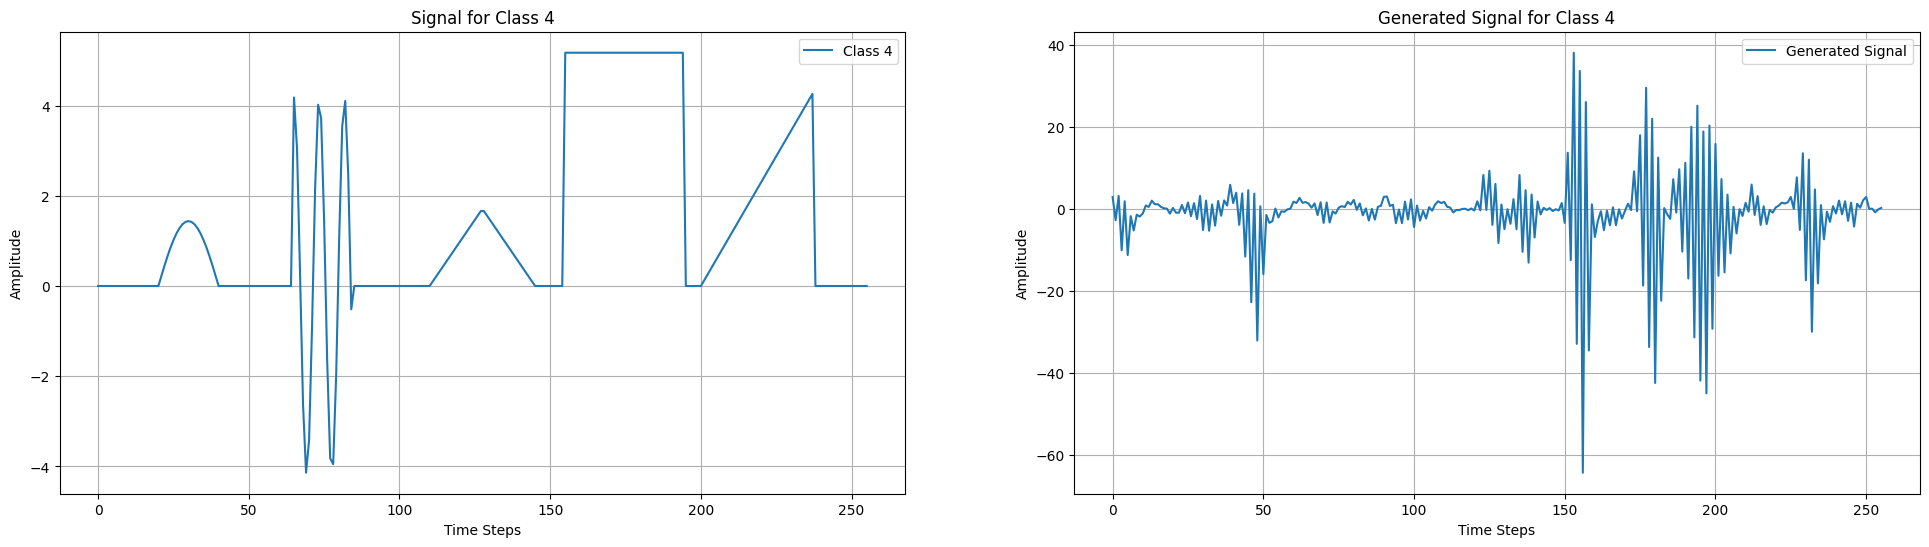

In [120]:
import torch
import matplotlib.pyplot as plt
import numpy as np
def custom_collate_fn(batch):
    signals = torch.stack([item['signals'] for item in batch]).unsqueeze(1)  # Adds a channel dimension
    gt = torch.stack([item['gt'] for item in batch])
    sc = torch.stack([item['sc'] for item in batch])
    return {'signals': signals, 'gt': gt, 'sc': sc}

def plot_signal_from_class(model, class_label):
    model.eval()  # Set the model to evaluation mode
    num_samples = 1  # Number of samples to generate
    length = 256  # Length of the signal

    project_folder_path = 'C:/Users/Alexia'
    datasets_folder_path = os.path.join(project_folder_path, 'datasets')
    train_set_path = os.path.join(datasets_folder_path, 'train_set_5class.pth')
    train_loader = DataLoader(torch.load(train_set_path), batch_size=128, shuffle=True, collate_fn=custom_collate_fn)

    found = False
    for batch_no, data_entry in enumerate(train_loader, start=1):
        signals = data_entry['signals']
        class_labels = data_entry['sc']
        for i in range(signals.size(0)):
            if class_labels[i] == class_label:
                plt.figure(figsize=(24, 6))  # Increase figure size for better visibility
                
                # Plotting the original signal
                plt.subplot(1, 2, 1)
                plt.plot(signals[i].squeeze(), label=f'Class {class_label}')
                plt.title(f'Signal for Class {class_label}')
                plt.xlabel('Time Steps')
                plt.ylabel('Amplitude')
                plt.legend()
                plt.grid(True)
                
                # Generate new signal
                inputs = torch.randn((num_samples, 1, length))
                class_labels = torch.full((num_samples,), fill_value=class_label, dtype=torch.long)
                with torch.no_grad():
                    outputs = model.p_sample_loop(inputs, class_labels)

                # Plotting generated signal
                outputs = outputs.squeeze().cpu().numpy()
                plt.subplot(1, 2, 2)
                plt.plot(outputs, label='Generated Signal')
                plt.title(f'Generated Signal for Class {class_label}')
                plt.xlabel('Time Steps')
                plt.ylabel('Amplitude')
                plt.legend()
                plt.grid(True)

                plt.show()  # Show all plots at once
                found = True
                break
        if found:
            break


plot_signal_from_class(model, class_label=4)

#100+ signals display

In [51]:
import numpy as np

def makesignal(noise_level, signalclass):
    startoffset = 20
    maxseglength = 45
    minseglength = 20
    maxzero = 40  # Maximum length of zero segments
    minzero = 1  # Minimum length of zero segments
    
    # Define signal patterns
    def square(length, amp, signalclass):
        delta = float(signalclass) - 0.5
        return (amp + delta) * np.ones(length)

    def sine(length, amp, signalclass):
        return amp * np.sin(np.pi * np.linspace(0, 1, length))

    def ramp(length, amp, signalclass):
        return amp * np.linspace(0, 1, length)

    def cosine(length, amp, signalclass):
        delta = 0.25 * np.random.randn() + (float(signalclass) - 0.5)
        return amp * np.cos(np.pi * (1 + delta) * np.linspace(0, 1, length))

    def udramp(length, amp, signalclass):
        if length % 2 == 1:
            length += 1
        a = np.linspace(0, amp, int(length / 2))
        b = np.linspace(amp, 0, int(length / 2))
        return np.concatenate((a, b))

    def getpattern(choice, seglength, signalclass):
        switcher = {1: square, 2: sine, 3: ramp, 4: cosine, 5: udramp}
        option = switcher.get(choice, lambda: np.zeros(seglength))
        segment = option(seglength, 2.0 + np.random.randn(), signalclass)
        return segment

    def pick(Choices):
        x = np.random.permutation(Choices)
        selected = x[0]
        return selected

    # Initialize signal and pattern type
    n = np.linspace(0, 1, 256)
    y = np.zeros_like(n)
    Choices = [1, 2, 3, 4, 5]
    patterntype = np.zeros((len(y), len(Choices) + 1))
    current_pos = startoffset

    # Generate signal with variable zero lengths
    while current_pos < len(y) - maxseglength and Choices:
        seglength = np.round((maxseglength - minseglength) * np.random.rand()) + minseglength
        Choice = pick(Choices)
        seglength = int(seglength)
        segment = getpattern(Choice, seglength, signalclass)
        zerolength = np.random.randint(minzero, maxzero + 1)
        y[current_pos:current_pos + len(segment)] = segment
        patterntype[current_pos:current_pos + seglength, Choice] = 1
        current_pos += seglength + zerolength
        Choices.remove(Choice)

    y += noise_level * np.random.randn(len(y))

    return y, patterntype, signalclass

def generate_balanced_dataset(num_samples_per_class, noise_level):
    num_classes = 5
    num_samples = num_samples_per_class * num_classes
    signals = np.zeros((num_samples, 256))
    masks = np.zeros((num_samples, 256, 6))
    signalclasses = np.zeros(num_samples)

    for signalclass in range(num_classes):
        for i in range(num_samples_per_class):
            index = i + num_samples_per_class * signalclass
            s, gt, _ = makesignal(noise_level, signalclass)
            signals[index, :] = s
            masks[index, :, :] = gt
            signalclasses[index] = signalclass

    return signals, masks, signalclasses

import torch as T
import numpy as np



class SynthSignalsDataset(T.utils.data.Dataset):
    """A PyTorch Dataset class for a balanced dataset of synthetic signals."""

    def __init__(self, num_samples_per_class, noise_level=0.0, device=None):
        """
        Initialize the dataset with balanced classes.
        
        Parameters:
        num_samples_per_class (int): Number of samples per class.
        noise_level (float): The noise level to be added to the signals.
        device (str, optional): The device to store the tensors on (e.g., 'cuda' or 'cpu').
        """
        x_tmp, y_tmp, signalclasses = generate_balanced_dataset(num_samples_per_class, noise_level)
        self.x_data = T.tensor(x_tmp, dtype=T.float32).to(device)
        self.y_data = T.tensor(y_tmp, dtype=T.long).to(device)
        self.signalclasses = T.tensor(signalclasses, dtype=T.long).to(device)

    def __len__(self):
        """Return the number of samples in the dataset."""
        return len(self.x_data)

    def __getitem__(self, idx):
        """
        Retrieve a single sample from the dataset.
        
        Parameters:
        idx (int): The index of the sample to retrieve.
        
        Returns:
        dict: A dictionary containing the signals, ground truth, and class.
        """
        signals = self.x_data[idx]
        gt = self.y_data[idx]
        sc = self.signalclasses[idx]
        return {'signals': signals, 'gt': gt, 'sc': sc}
    




In [52]:
from torch.utils.data import DataLoader

import torch
import os


# Parameters
num_samples_per_class = 5000  # Number of samples per class
noise_level = 0  # Noise level for signal generation
batch_size = 32  # Batch size for training

# Create dataset
dataset = SynthSignalsDataset(num_samples_per_class, noise_level, device='cpu')

# Create the directory if it does not exist
save_path = 'C:/Users/Alexia/datasets'
if not os.path.exists(save_path):
    os.makedirs(save_path)

# Save the dataset
dataset_save_path = os.path.join(save_path, 'rand_0_no.pth')
torch.save(dataset, dataset_save_path)